In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
radbio_data = pd.read_csv("GSE43151_gs.csv")
num_genes = radbio_data.shape[1] - 1 
gene_ids = [int(i) for i in radbio_data.columns[0:num_genes]]
print(len(gene_ids))
gene_dictionary = pd.read_csv("ncbi_dataset.tsv", sep='\t', header=0)
print(gene_dictionary)

10874
       NCBI GeneID     Symbol  \
0             7157       TP53   
1             1956       EGFR   
2             7124        TNF   
3              348       APOE   
4             7422      VEGFA   
...            ...        ...   
45507         9596     OR1R1P   
45508         9597  SMAD5-AS1   
45509        96626      LIMS3   
45510         9808   KIAA0087   
45511         9831     ZNF623   

                                             Description Taxonomic Name  \
0                                      tumor protein p53   Homo sapiens   
1                       epidermal growth factor receptor   Homo sapiens   
2                                  tumor necrosis factor   Homo sapiens   
3                                       apolipoprotein E   Homo sapiens   
4                   vascular endothelial growth factor A   Homo sapiens   
...                                                  ...            ...   
45507  olfactory receptor family 1 subfamily R member...   Homo sapiens 

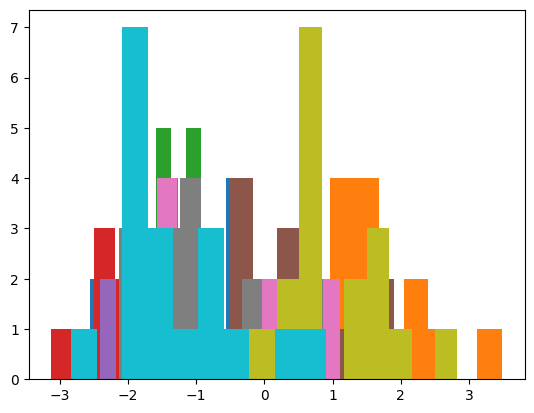

In [3]:
control = radbio_data[radbio_data['Dose'] == '0.Gy']
control_data = control.drop(columns=["Dose"])
for gene in np.arange(10):
    plt.hist(control_data.iloc[:,gene])

In [4]:
# Which genes are in the dataset and are also protein coding 
gene_data = gene_dictionary.loc[gene_dictionary['NCBI GeneID'].isin(gene_ids)]
protein_gene_data = gene_data.loc[gene_data['Gene Type']=='PROTEIN_CODING']
print(protein_gene_data)


       NCBI GeneID    Symbol                                Description  \
0             7157      TP53                          tumor protein p53   
2             7124       TNF                      tumor necrosis factor   
3              348      APOE                           apolipoprotein E   
7             4524     MTHFR        methylenetetrahydrofolate reductase   
9             3091     HIF1A   hypoxia inducible factor 1 subunit alpha   
...            ...       ...                                        ...   
45487        93134    ZNF561                    zinc finger protein 561   
45488        93190   CFAP107  cilia and flagella associated protein 107   
45492        93622  MRFAP1L2   Morf4 family associated protein 1 like 2   
45500        94059     LENG9        leukocyte receptor cluster member 9   
45511         9831    ZNF623                    zinc finger protein 623   

      Taxonomic Name Common Name       Gene Type  Transcripts  \
0       Homo sapiens       human  

In [5]:
final_gene_set = [str(i) for i in protein_gene_data['NCBI GeneID']]
final_data_set = radbio_data[final_gene_set]
final_column_set = final_gene_set + ["Dose"]
final_data_set_w_condition = radbio_data[final_column_set]


In [6]:
# Permutation testing
corr_mat = final_data_set.corr('pearson').to_numpy()
np.fill_diagonal(corr_mat, 0)
print(np.max(corr_mat))
random_corr_coef = []
for i in range(100):
    shuffled_array = np.zeros(final_data_set.shape)
    for row in np.arange(final_data_set.shape[0]):
        shuffled_array[row] = np.random.permutation(final_data_set.iloc[row])
    shuffled_final_data_set = pd.DataFrame(data=shuffled_array)
    shuffle_corr_mat = shuffled_final_data_set.corr('pearson')

    shuffle_corr_mat = shuffle_corr_mat.to_numpy()
    np.fill_diagonal(shuffle_corr_mat, 0)
    random_corr_coef.append(np.max(shuffle_corr_mat))

0.9850945543290598


KeyboardInterrupt: 

In [7]:
#np.savetxt('random_corr_coef.txt', np.array(random_corr_coef))
random_corr_coef = np.loadtxt('random_corr_coef.txt')

In [8]:
import scipy.stats as st
ci_interval = st.t.interval(0.95, len(random_corr_coef)-1, loc=np.mean(random_corr_coef), scale=st.sem(random_corr_coef))
cutoff = ci_interval[1]

In [9]:
corr_mat[corr_mat<=cutoff] = 0
corr_mat[corr_mat>cutoff] = 1
print(f"Superstructure contains {np.sum(corr_mat)} edges which is {np.sum(corr_mat)/(corr_mat.shape[0]**2)} fraction of all possible edges")

Superstructure contains 2789340.0 edges which is 0.02848276072773661 fraction of all possible edges


In [10]:
from cd_v_partition.causal_discovery import ges_local_learn
final_data_set_w_condition = final_data_set_w_condition.rename(mapper={"Dose":"target"}, axis=1)
obs_final_data_set_w_condition = final_data_set_w_condition
obs_final_data_set_w_condition['target'] = np.zeros(radbio_data.shape[0])
est_dag = ges_local_learn((corr_mat, obs_final_data_set_w_condition), use_skel=True)

start
running giesl skel shape is (9896, 9896), num edges is 2789340.0


In [ ]:
print(np.sum(est_dag))

(9896, 9896)